# Final modeling

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

We decided to add a new feature to our dataset because it turns out that it could improve the performace of our models.

In [7]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

df_all = pd.concat([df, df_test])

In [8]:
X = df.drop(columns=['Class'])
y = df['Class']

X_test = df_test.drop(columns=["Class"])
y_test = df_test["Class"]

In [9]:
pd.set_option('display.float_format', '{:.4f}'.format)

# 1. Basic models evaluation

In this section we will try to evaluate some models based on our not processed data to have some baseline for future improvement

In [10]:
def evaluate_model_basic(models, X, y, X_test, y_test):
    results = []
    for model_name, model in models:
        if model_name == 'XGBoost':
            y = LabelEncoder().fit_transform(y)
            y_test = LabelEncoder().fit_transform(y_test)
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        results.append((model_name, accuracy, precision, recall))
    results = pd.DataFrame(results, columns=['Model Name', 'Accuracy', 'Precision', 'Recall'])
    results.sort_values('Accuracy', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    return results

### Models that we will choose from to pick the best 5

In [11]:
models = [
    ('Dummy Classifier', DummyClassifier(strategy='most_frequent')),
    ('Decision Tree', DecisionTreeClassifier(random_state=311, max_depth=9, max_leaf_nodes=28, min_samples_leaf=2, criterion='log_loss')),
    ('SVC', SVC(kernel='linear', random_state=311)),
    ('Linear SVC', LinearSVC(random_state=311)),
    ('K Nearest Neighbors', KNeighborsClassifier(algorithm='auto', weights ='distance', n_neighbors=15, p=2)),
    ('Random Forest', RandomForestClassifier(random_state=311)),
    ('LGBM', LGBMClassifier(random_state=311)),
    ('XGBoost', XGBClassifier(random_state=311))
]

In [8]:
results = evaluate_model_basic(models, X, y, X_test, y_test)
print(results)

            Model Name  Accuracy  Precision  Recall
0                 LGBM    0.9286     0.9289  0.9286
1              XGBoost    0.9286     0.9289  0.9286
2        Random Forest    0.9220     0.9222  0.9220
3                  SVC    0.9108     0.9114  0.9108
4        Decision Tree    0.9080     0.9091  0.9080
5  K Nearest Neighbors    0.7118     0.7086  0.7118
6           Linear SVC    0.4781     0.4452  0.4781
7     Dummy Classifier    0.2606     0.0679  0.2606


# 2. Feature selection

We are using **Random Forest Classifier** to gain knowledge about numeric importances of features in our dataset

In [12]:
feature_names = [feature for feature in df.columns if feature != 'Class']

forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

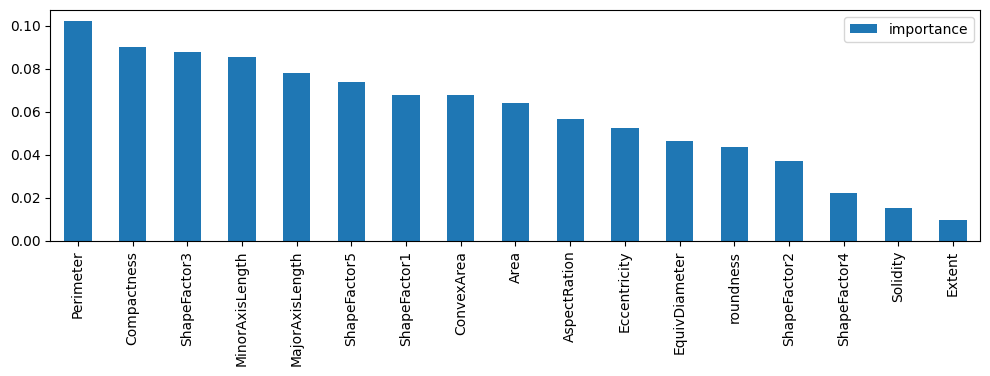

In [13]:
importances = forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 3))
feature_importances_sorted = feature_importances.sort_values('importance', ascending=False)
feature_importances_sorted.plot.bar(ax=ax)
ax.set_xticklabels(feature_importances_sorted['feature'])
importance_threshold = feature_importances.max()['importance']

It seems like we may disregard some columns, but we still need to determine how many of them needs to be removed.

In [14]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': forest.feature_importances_}).sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]
        
        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std(),
            'dropped_feature': feature_importances['feature'].iloc[i]
        })

    return pd.DataFrame(results)

In [115]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

(0.87, 0.93)

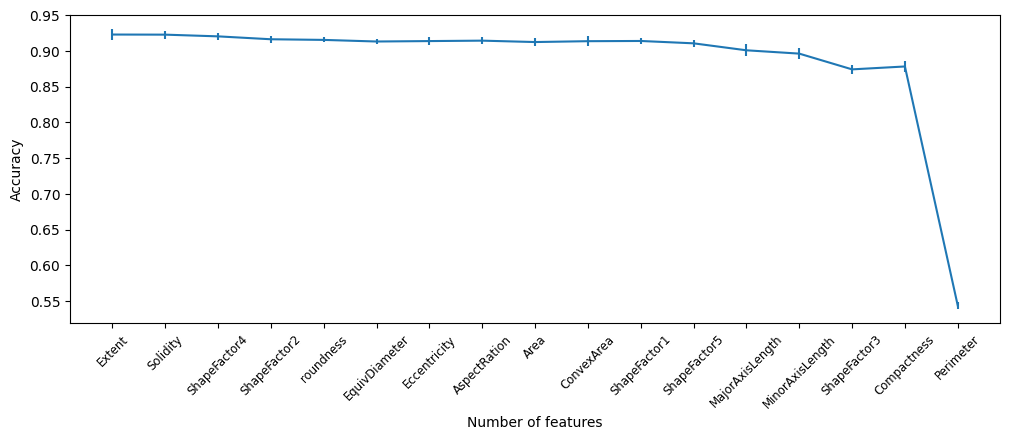

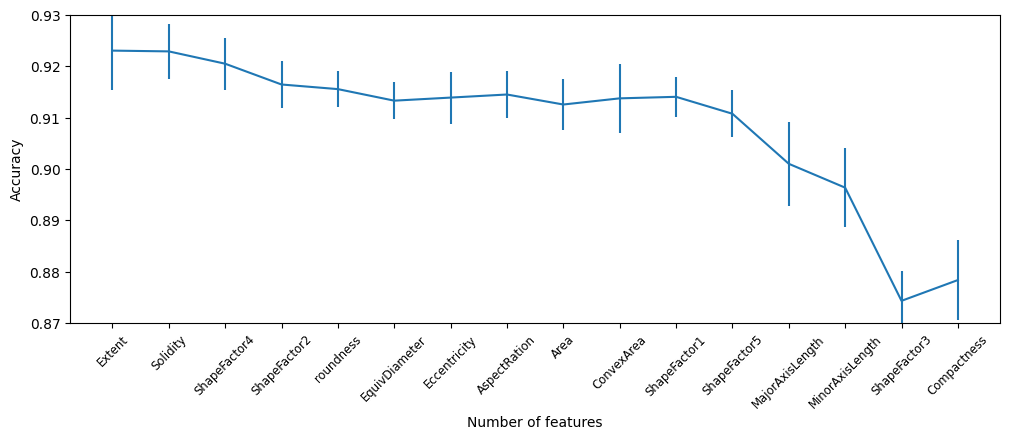

In [118]:
ax1 = results_with_1.plot(x='dropped_feature', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(len(results_with_1['dropped_feature'])))
ax1.set_xticklabels(results_with_1['dropped_feature'], rotation=45, fontsize='small')

ax2 = results_with_2.plot(x='dropped_feature', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(range(len(results_with_2['dropped_feature'])))
ax2.set_xticklabels(results_with_2['dropped_feature'], rotation=45, fontsize='small')

plt.ylim(0.87, 0.93)


These charts depict how much the accuracy changes as we sequentially remove columns from our data in the order of least significance (according to the Random Forest Classifier).

These indicate that we should definitely remove the column:

- ShapeFactor3

since after its removal, a significant improvement in accuracy is observed on the chart.

Additionally, we can also consider columns whose removal during the execution of the *evaluate_feature_importance* function slightly improves the model's accuracy or doesn't change it significantly.

### Selecting different sets of columns to remove

In [15]:
features_to_drop1 = ['ShapeFactor3', 'EquivDiameter', 'Eccentricity', 'Area', 'ConvexArea']
features_to_drop2 = ['ShapeFactor3', 'EquivDiameter', 'Eccentricity', 'Area', 'ConvexArea', 'Extent', 'ShapeFactor2', 'roundness', 'AspectRation']

# 3. Data preprocessing

In [16]:
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop, axis=1)

In [17]:
def standarize(df, column):
    return RobustScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

In [20]:
def test_models_with_preprocessing(df, models, columns_to_drop, to_standarize=False, cv=5):
    results = []
    X = df.drop(columns=['Class'])
    y = df['Class']
    for model_name, model in models:
        if model_name == 'XGBoost':
            y = LabelEncoder().fit_transform(y)

        for columns in columns_to_drop:
            X_transformed = drop_columns(X, columns)
            if to_standarize:
                for col in X_transformed.columns:
                    X_transformed[col] = standarize(X_transformed, col)
                
            scores = cross_validate(model, X_transformed, y, cv=cv,
                                    scoring=['accuracy', 'precision_weighted', 'recall_weighted'],
                                    return_train_score=False)
            accuracy = scores['test_accuracy'].mean()
            precision = scores['test_precision_weighted'].mean()
            recall = scores['test_recall_weighted'].mean()
            results.append((model_name, columns, accuracy, precision, recall))
    
    results = pd.DataFrame(results, columns=['Model Name', 'Columns Dropped', 'Accuracy', 'Precision', 'Recall'])
    results.sort_values('Accuracy', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    return results

### Creating preliminary models for testing column selection and scaling
We select the top 5 models from the earlier testing.

In [19]:
columns_to_drop = [
    features_to_drop1,
    features_to_drop2
]

models2 = [
    ('LGBM', LGBMClassifier(random_state=311)),
    ('XGBoost', XGBClassifier(random_state=311)),
    ('Random Forest', RandomForestClassifier(random_state=311)),
    ('SVC', SVC(kernel='linear', random_state=311)),
    ('Decision Tree', DecisionTreeClassifier(random_state=311, max_depth=9, max_leaf_nodes=28, min_samples_leaf=2, criterion='log_loss')),
]

In [21]:
results_dropped_columns_no_standarize = test_models_with_preprocessing(df_all, models2, columns_to_drop, to_standarize=False) 

In [22]:
results_dropped_columns_standarize = test_models_with_preprocessing(df_all, models2, columns_to_drop, to_standarize=True)

In [25]:
print("Results for models with columns dropped and no standarization ")
print(results_dropped_columns_no_standarize)
print("\n-----------------------------------\n")
print("Results for models with columns dropped and standarization")
print(results_dropped_columns_standarize)

Results for models with columns dropped and no standarization 
      Model Name                                    Columns Dropped  Accuracy  \
0           LGBM  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9298   
1        XGBoost  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9277   
2  Random Forest  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9268   
3  Random Forest  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9256   
4           LGBM  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9237   
5        XGBoost  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9234   
6            SVC  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9153   
7            SVC  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9152   
8  Decision Tree  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9047   
9  Decision Tree  [ShapeFactor3, EquivDiameter, Eccentricity, Ar...    0.9044   

   Precision  Recall  
0     0.9301  0.9298  

In [29]:
res1 = results_dropped_columns_no_standarize
res2 = results_dropped_columns_standarize

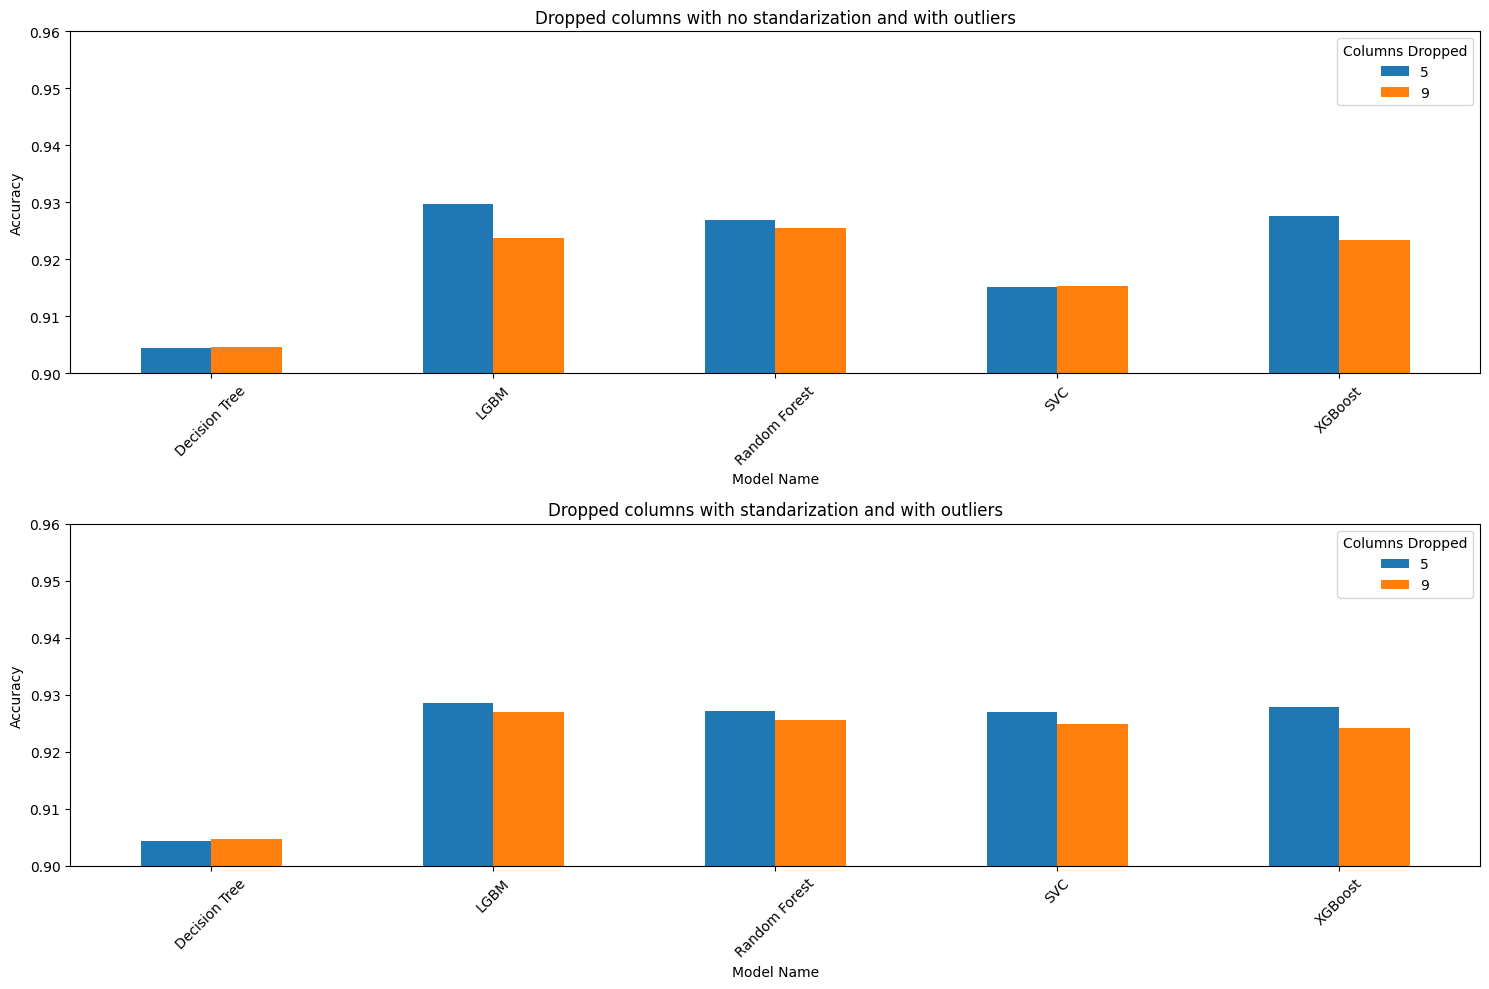

In [30]:
dataframes = [res1, res2]
titles = ['Dropped columns with no standarization and with outliers',
          'Dropped columns with standarization and with outliers']

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for i, ax in enumerate(axs.flatten()):
    df = dataframes[i]
    
    df['Columns Dropped'] = df['Columns Dropped'].apply(lambda x: ', '.join(x))

    df_pivot = df.pivot(index='Model Name', columns='Columns Dropped', values='Accuracy')

    df_pivot.plot(kind='bar', ax=ax)

    ax.set_title(titles[i])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model Name')
    ax.set_xticklabels(df_pivot.index, rotation=45)
    ax.set_ylim(0.90, 0.96)
    ax.legend(["5", "9"], title='Columns Dropped')

plt.tight_layout()
plt.show()

Conclusions:

- Standardizing parameters significantly improves the SVC model, while it has little impact on others.
- The best-performing models appear to be LGBM, RandomForest, SVC, and XGBoost, for which we will conduct hyperparameter tuning in the next phase of the project.

# 4. Hyperparameter tuning

In [ ]:
def get_best_params(X, y, model, param_grid, columns_to_drop):
    y = LabelEncoder().fit_transform(y)
    X_transformed = drop_columns(X, columns_to_drop)
    for col in X_transformed.columns:
        X_transformed[col] = standarize(X_transformed, col)
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_transformed, y)
    return grid.best_params_

In [ ]:
param_grid_svc = {
    "C": [i for i in range(1, 50)],
    "kernel": ['rbf', 'linear'],
    "gamma": ['scale', 'auto']
}

param_grid_rf = {
    "n_estimators": [i for i in range(10, 150, 10)],
    "max_depth": [i for i in range(1, 8)],
    "min_samples_split": [i for i in range(2, 10)],
    "min_samples_leaf": [i for i in range(1, 10)],
    "criteria": ['gini', 'entropy', 'log_loss'],
    "bootstrap": [True, False]
}

param_grid_lgbm = {
    "boosting_type": ['gbdt', 'dart', 'goss', 'rf'],
    "max_depth": [i for i in range(1, 8)],
    "n_estimators": [i for i in range(10, 150, 10)],
}

param_grid_xgb = {
    "booster" : ['gbtree', 'gblinear'],
    "eta" : [0.05, 0.1, 0.2],
    "max_depth" : [2, 3, 4, 5],
    "min_child_weight" : [0.05, 0.1, 0.5, 1, 3]
}

In [28]:
best_params_svc = get_best_params(X, y, SVC(random_state = 311), param_grid_svc, features_to_drop2)
print(f"Best params for SVC: {best_params_svc}")

Best params for SVC: {'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}


In [32]:
best_params_rf = get_best_params(X, y, RandomForestClassifier(), param_grid_rf, features_to_drop2)
print(f"Best params for Random Forest: {best_params_rf}")

Best params for Random Forest: {}


In [35]:
best_params_lgbm = get_best_params(X, y, LGBMClassifier(), param_grid_lgbm, features_to_drop2)
print(f"Best params for LGBM: {best_params_lgbm}")

Best params for LGBM: {'boosting_type': 'goss', 'max_depth': 3, 'n_estimators': 120}


In [41]:
best_params_xgb = get_best_params(X, y, XGBClassifier(), param_grid_xgb, features_to_drop2)
print(f"Best params for XGBoost: {best_params_xgb}")

Best params for XGBoost: {'booster': 'gbtree', 'eta': 0.2, 'max_depth': 3, 'min_child_weight': 0.05}


# 5. Model scoring

In [24]:
# SVM_best = SVC(random_state=311, **best_params_svc)
# RF_best = RandomForestClassifier(random_state=311, **best_params_rf)
# LGBM_best = LGBMClassifier(random_state=311, **best_params_lgbm)
# XGB_best = XGBClassifier(random_state=311, **best_params_xgb)

SVM_best = SVC(random_state=311, C=9, gamma='auto', kernel='rbf')
RF_best = RandomForestClassifier(random_state=311)
LGBM_best = LGBMClassifier(random_state=311, boosting_type='goss', max_depth=3, n_estimators=120, verbose=-1)
XGB_best = XGBClassifier(random_state=311, booster = 'gbtree', eta=0.2, max_depth=3, min_child_weight=0.05)

models_best = [
    ('SVM', SVM_best),
    ('Random Forest', RF_best),
    ('LGBM', LGBM_best),
    ('XGBoost', XGB_best)
]

In [31]:
def prepare_data(df):
    df = df.copy()
    df.drop(columns=features_to_drop2, inplace=True)
    for col in df.columns:
        if col != 'Class':
            df[col] = standarize(df, col)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Class']), df['Class'], test_size=0.2, random_state=311)
    return X_train, y_train, X_test, y_test

In [32]:
X_train, y_train, X_test, y_test = prepare_data(df_all)

In [33]:
for model_name, model in models_best:
    if model_name == 'XGBoost':
        y_train = LabelEncoder().fit_transform(y_train)
        y_test = LabelEncoder().fit_transform(y_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
    print("\n----------------------------------------------------------\n")

Model: SVM
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.91      0.93       181
      BOMBAY       1.00      1.00      1.00        77
        CALI       0.95      0.95      0.95       249
    DERMASON       0.90      0.95      0.93       491
       HOROZ       0.96      0.95      0.95       268
       SEKER       0.96      0.97      0.96       295
        SIRA       0.89      0.83      0.86       345

    accuracy                           0.93      1906
   macro avg       0.94      0.94      0.94      1906
weighted avg       0.93      0.93      0.93      1906

Accuracy: 0.9302

----------------------------------------------------------

Model: Random Forest
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.87      0.90       181
      BOMBAY       1.00      1.00      1.00        77
        CALI       0.94      0.94      0.94       249
    DERMASON       0.91      0.96      0.93       491
       HOROZ       0.9

It seems like the best model could be SVM

## Stacking

In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacked_model = StackingClassifier(estimators=models_best, final_estimator=LogisticRegression())
stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)


In [36]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       181
           1       1.00      1.00      1.00        77
           2       0.96      0.95      0.95       249
           3       0.91      0.95      0.93       491
           4       0.95      0.96      0.96       268
           5       0.96      0.97      0.96       295
           6       0.89      0.83      0.86       345

    accuracy                           0.93      1906
   macro avg       0.94      0.94      0.94      1906
weighted avg       0.93      0.93      0.93      1906

Accuracy: 0.9328


## Our 2 go-to models

In [37]:
model1 = SVC(random_state=311, C=9, gamma='auto', kernel='rbf')

SVM_best = SVC(random_state=311, C=9, gamma='auto', kernel='rbf')
RF_best = RandomForestClassifier(random_state=311)
LGBM_best = LGBMClassifier(random_state=311, boosting_type='goss', max_depth=3, n_estimators=120, verbose=-1)
XGB_best = XGBClassifier(random_state=311, booster = 'gbtree', eta=0.2, max_depth=3, min_child_weight=0.05)

models_best = [
    ('SVM', SVM_best),
    ('Random Forest', RF_best),
    ('LGBM', LGBM_best),
    ('XGBoost', XGB_best)
]

model2 = StackingClassifier(estimators=models_best, final_estimator=LogisticRegression())

In [38]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)


Model 1:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       181
           1       1.00      1.00      1.00        77
           2       0.95      0.95      0.95       249
           3       0.90      0.95      0.93       491
           4       0.96      0.95      0.95       268
           5       0.96      0.97      0.96       295
           6       0.89      0.83      0.86       345

    accuracy                           0.93      1906
   macro avg       0.94      0.94      0.94      1906
weighted avg       0.93      0.93      0.93      1906

Accuracy:  0.9302


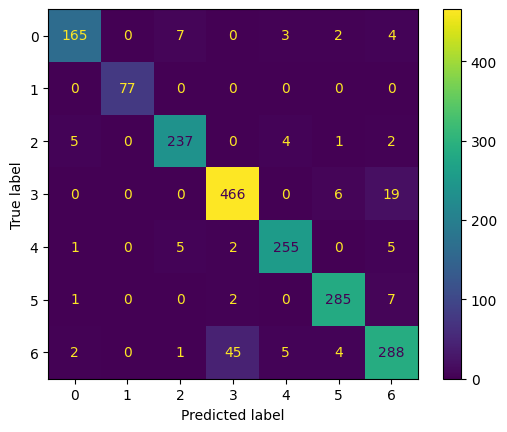

In [40]:
print("Model 1:\n")
print(classification_report(y_test, y_pred1))
print("Accuracy: ", round(accuracy_score(y_test, y_pred1), 4))
cm1 = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()


Model 2:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       181
           1       1.00      1.00      1.00        77
           2       0.96      0.95      0.95       249
           3       0.91      0.95      0.93       491
           4       0.95      0.96      0.96       268
           5       0.96      0.97      0.96       295
           6       0.89      0.83      0.86       345

    accuracy                           0.93      1906
   macro avg       0.94      0.94      0.94      1906
weighted avg       0.93      0.93      0.93      1906

Accuracy:  0.9328


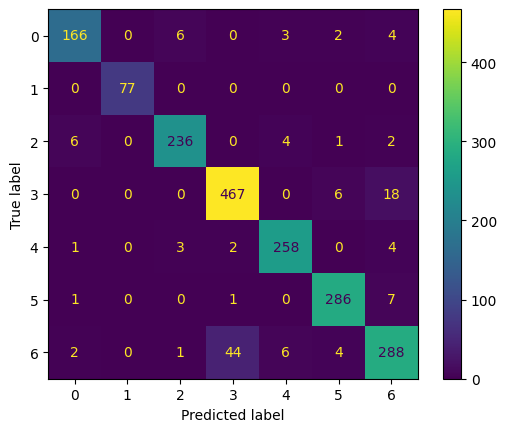

In [42]:
print("Model 2:\n")
print(classification_report(y_test, y_pred2))
print("Accuracy: ", round(accuracy_score(y_test, y_pred2), 4))
cm2 = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()

## Validation

In [38]:
def prepare_val_data(df):
    df = df.copy()
    df.drop(columns=features_to_drop2, inplace=True)
    for col in df.columns:
        if col != 'Class':
            df[col] = standarize(df, col)
    X = df.drop(columns=['Class'])
    y = df['Class']
    return X, y

In [40]:
df_val = pd.read_csv('../data/df_validate.csv')
df_val['ShapeFactor5'] = df_val['MajorAxisLength'] / df_val['Perimeter']
X_val, y_val = prepare_val_data(df_val)

y_pred1 = model1.predict(X_val)
y_pred2 = model2.predict(X_val)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Model 1
Accuracy:  0.9258080313418218
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.91      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.95      0.95      0.95       489
    DERMASON       0.92      0.91      0.92      1064
       HOROZ       0.96      0.96      0.96       578
       SEKER       0.94      0.95      0.95       608
        SIRA       0.86      0.88      0.87       791

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084



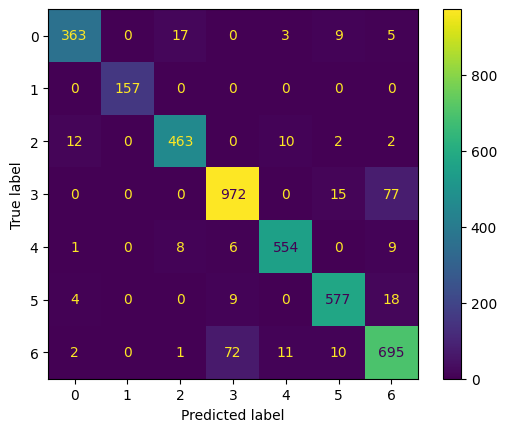

In [42]:
print("Model 1")
print("Accuracy: ", accuracy_score(y_val, y_pred1))
print(classification_report(y_val, y_pred1))
cm1 = confusion_matrix(y_val, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()

Model 2
Accuracy:  0.9255631733594515
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.92      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.95      0.93      0.94       489
    DERMASON       0.91      0.92      0.91      1064
       HOROZ       0.96      0.96      0.96       578
       SEKER       0.94      0.95      0.95       608
        SIRA       0.87      0.87      0.87       791

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084



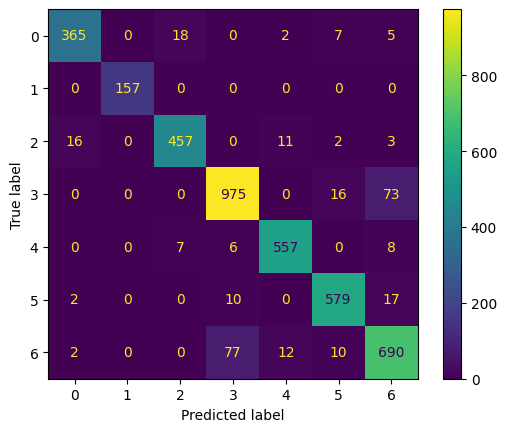

In [43]:
print("Model 2")
print("Accuracy: ", accuracy_score(y_val, y_pred2))
print(classification_report(y_val, y_pred2))
cm1 = confusion_matrix(y_val, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()